In [ ]:
%pip install requests scipy scikit-learn pandas numpy matplotlib seaborn 

In [25]:
import os, zipfile, requests, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
ROOT = Path("uci_har_raw")
SEED = 1
torch.manual_seed(SEED)
np.random.seed(SEED)
device = torch.device(
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
    else "cpu"
)

ROOT.mkdir(parents=True, exist_ok=True)
zip_path = ROOT / "UCI_HAR_Dataset.zip"
#if not zip_path.exists():
    #print("Downloading UCI HAR…")
    #r = requests.get(URL, timeout=60)
    #r.raise_for_status()
    #zip_path.write_bytes(r.content)

data_dir = ROOT / "UCI HAR Dataset"
#if not data_dir.exists():
#    with zipfile.ZipFile(zip_path) as zf:
#        zf.extractall(ROOT)


def load_matrix(p):
    # each file is N x 128 whitespace-separated float matrix
    return np.loadtxt(p).astype(np.float32)


def load_raw_set(split="train"):
    
    base = "./data/uci_har_raw/UCI HAR Dataset/train/Inertial Signals"
    chans = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z",
    ]
    mats = [load_matrix(base + "/" + f"{c}_{split}.txt") for c in chans]
    X = np.stack(mats, axis=1)
    y = np.loadtxt("./data/uci_har_raw/UCI HAR Dataset/" + split + "/" + f"y_{split}.txt").astype(int).ravel() - 1
    return X, y


Xtr_raw, ytr = load_raw_set("train")
Xte_raw, yte = load_raw_set("test")
print("Raw train:", Xtr_raw.shape, "Raw test:", Xte_raw.shape)

Raw train: (7352, 9, 128) Raw test: (2947, 9, 128)


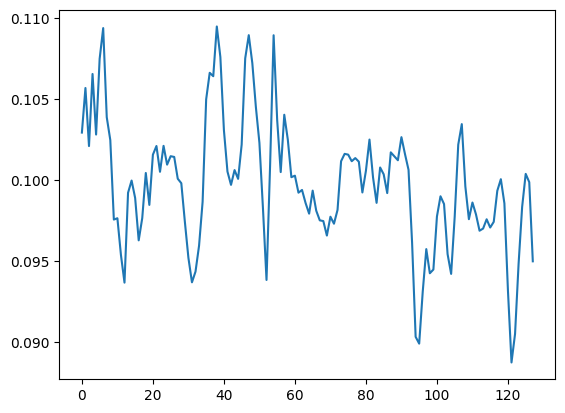

In [33]:

plt.plot(Xtr_raw[0][8])

Epoch 01  loss 1.7896
Epoch 02  loss 1.7874
Epoch 03  loss 1.7873
Epoch 04  loss 1.7863
Epoch 05  loss 1.7862
Epoch 06  loss 1.7862
Epoch 07  loss 1.7853
Epoch 08  loss 1.7851
Epoch 09  loss 1.7857
Epoch 10  loss 1.7856
Epoch 11  loss 1.7851
Epoch 12  loss 1.7844
Epoch 13  loss 1.7862
Epoch 14  loss 1.7856
Epoch 15  loss 1.7856
Epoch 16  loss 1.7847
Epoch 17  loss 1.7851
Epoch 18  loss 1.7846
Epoch 19  loss 1.7856
Epoch 20  loss 1.7852
Epoch 21  loss 1.7849
Epoch 22  loss 1.7846
Epoch 23  loss 1.7847
Epoch 24  loss 1.7856
Epoch 25  loss 1.7849
Epoch 26  loss 1.7850
Epoch 27  loss 1.7852
Epoch 28  loss 1.7847
Epoch 29  loss 1.7847
Epoch 30  loss 1.7848
Epoch 31  loss 1.7849
Epoch 32  loss 1.7847
Epoch 33  loss 1.7846
Epoch 34  loss 1.7849
Epoch 35  loss 1.7841
Epoch 36  loss 1.7843
Epoch 37  loss 1.7845
Epoch 38  loss 1.7838
Epoch 39  loss 1.7844
Epoch 40  loss 1.7850
Epoch 41  loss 1.7848
Epoch 42  loss 1.7847
Epoch 43  loss 1.7840
Epoch 44  loss 1.7839
Epoch 45  loss 1.7845
Epoch 46  

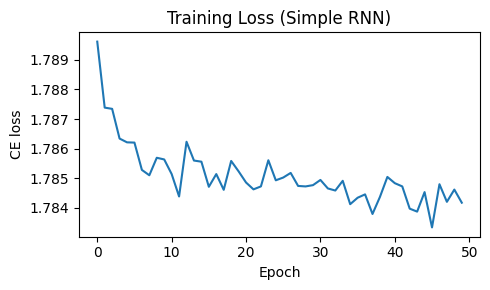

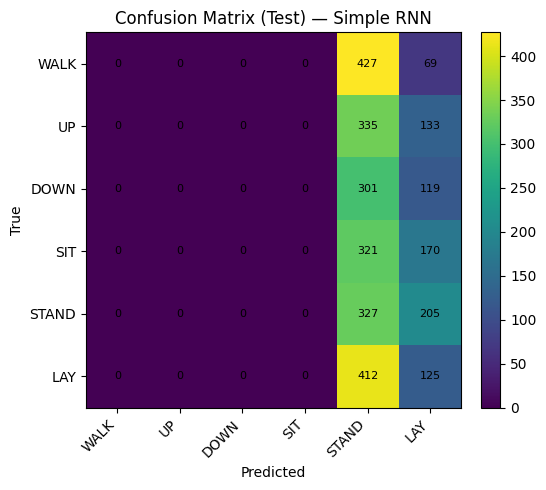

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

try:
    device
except NameError:
    device = torch.device(
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if getattr(torch.backends, "mps", None) and torch.backends.mps.is_available()
        else "cpu"
    )

# Rohdaten: (N, C, T) -> (N, T, C) = (N, 128, 9)
Xtr_seq = np.transpose(Xtr_raw, (0, 2, 1)).astype(np.float32)
Xte_seq = np.transpose(Xte_raw, (0, 2, 1)).astype(np.float32)

# Pro-Kanal-Skalierung über alle Zeitpunkte des Trainings
scaler = StandardScaler().fit(Xtr_seq.reshape(-1, Xtr_seq.shape[-1]))
Xtr_s = scaler.transform(Xtr_seq.reshape(-1, Xtr_seq.shape[-1])).reshape(Xtr_seq.shape).astype(np.float32)
Xte_s = scaler.transform(Xte_seq.reshape(-1, Xte_seq.shape[-1])).reshape(Xte_seq.shape).astype(np.float32)

train_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xtr_s), torch.from_numpy(ytr.astype(np.int64))),
    batch_size=128, shuffle=True,drop_last=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(Xte_s), torch.from_numpy(yte.astype(np.int64))),
    batch_size=128, shuffle=False, drop_last=True
)



class RNNClassifier(nn.Module):
    def __init__(self, input_dim=9, hidden_dim=64, n_classes=6, n_layers=1, dropout=0.0):
        super().__init__()
        self.rnn = nn.RNN( # RNN designt Features automatisch
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            nonlinearity="tanh",
            #batch_first=True,
            dropout=dropout if n_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_dim, n_classes)

    def forward(self, x):
        # x: (B, T, C)
        _, h_n = self.rnn(x)         # h_n: (num_layers, B, H)
        h_last = h_n[-1]             # (B, H)
        return self.fc(h_last)       # (B, n_classes)

n_classes = 6
model = RNNClassifier(input_dim=9, hidden_dim=32, n_classes=n_classes, n_layers=3, dropout=0.2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = nn.CrossEntropyLoss()

epochs = 50
losses = []
for ep in range(1, epochs + 1):
    model.train()
    total, n = 0.0, 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        logits = model(xb)
        loss = crit(logits, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        total += loss.item() * xb.size(0)
        n += xb.size(0)
    losses.append(total / n)
    print(f"Epoch {ep:02d}  loss {losses[-1]:.4f}")

# Evaluation
model.eval()
logits_all, y_all = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits_all.append(model(xb.to(device)).cpu())
        y_all.append(yb)
logits = torch.cat(logits_all, dim=0)
y_true = torch.cat(y_all, dim=0).numpy()
y_pred = logits.argmax(1).numpy()
acc = accuracy_score(y_true, y_pred)
print(f"\nTest accuracy: {acc * 100:.2f}%")

# Plots
plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.title("Training Loss (Simple RNN)")
plt.xlabel("Epoch")
plt.ylabel("CE loss")
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_true, y_pred)
classes = ["WALK", "UP", "DOWN", "SIT", "STAND", "LAY"]

plt.figure(figsize=(6, 5))
im = plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test) — Simple RNN")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(6), classes, rotation=45, ha="right")
plt.yticks(range(6), classes)
for i in range(6):
    for j in range(6):
        plt.text(j, i, cm[i, j], ha="center", va="center", fontsize=8)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
